In [1]:
import numpy as np
import matplotlib.pyplot as plt

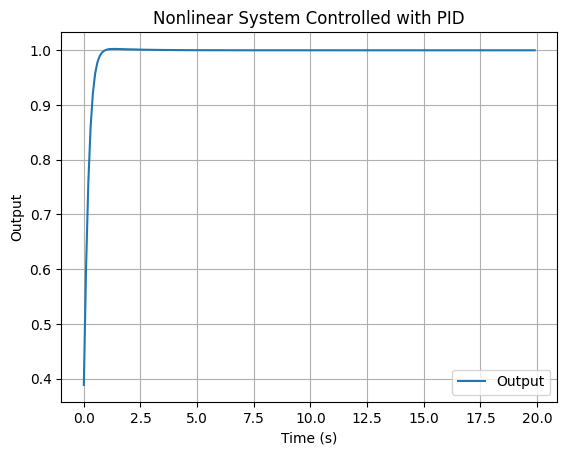

In [ ]:

class NonlinearDynamicalModel:
    def __init__(self, x0):
        """
        Parameters:
        x0 : Initial state
        """
        self.x = x0
        # Battery parameters
        self.P_el_rest = 2.0 # W
        self.Q_BT_max = 3.0 * 3600 # Ah - As
        self.R_BT_int = 0.1 # Ohm
        self.U_BT_oc = 4.2 # V TODO change to a function of SoC or Q_BT

        # Fan parameters
        self.I_FAN = 0.13 # A
        self.U_FAN = 12.0 # V

        # LED parameters
        self.I_LED = 0.02 # A
        self.x_LED = 0.5 # duty cycle
        self.P_r = 1.18 # W

        # Top thermal parameters
        self.R_3_lambda = 0.1 # K/W
        self.R_Al_lambda = 5.0 # K/W
        self.R_i = 25.0 # K/W
        self.T_air = 25.0 + 273.15 # K

        # Heat pump - peltier module
        # TODO get data from csv file saved from matlab
        self.R_M = 1.3164 # Ohm
        self.S_M = 0.0237 # V/K
        self.K_M = 0.2569 # W/K

    def dynamics(self, x, u):
        """
        u1: PWM peltier module
        u2: PWM fan

        x1: SoC
        x2: T_HP_c
        x3: T_HP_h
        """
        self.x_HP = u[0]
        self.x_FAN = u[1]

        self.x_SoC = x[0]
        self.T_HP_c = x[1]
        self.T_HP_h = x[2]

        # Fan
        self.P_FAN = self.I_FAN * self.U_FAN * self.x_FAN # W
        self.R_air_alpha = 1.0 # K/W # TODO change to a function of the fan PWM

        # LED
        self.P_el_LED = self.I_LED * self.U_sys * self.x_LED # W
        self.Q_LED = self.P_el_LED - self.P_r # W

        # Top thermal

        # Heat pump - peltier module
        self.U_HP = self.U_sys * self.x_HP # V
        self.DeltaT_HP = (self.U_HP - self.R_M * self.I_HP) / self.S_M # K
        self.Q_HP_c = self.S_M * self.I_HP * self.T_HP_c - 0.5 * self.R_M * self.I_HP^2 - self.K_M * self.DeltaT_HP # W

        # Battery
        self.P_BT = self.P_el_LED + self.P_el_HP + self.P_FAN + self.P_el_rest # W
        # Limit the power to the battery
        # TODO self.U_BT_oc as a function of state x
        self.P_BT = min(self.P_BT, self.U_BT_oc^2 / (4 * self.R_BT_int)) # W

        self.I_BT = (self.U_BT_oc - np.sqrt(self.U_BT_oc^2 - 4 * self.P_BT * self.R_BT_int)) / (2 * self.R_BT_int) # A
        self.U_sys = self.U_BT_oc - self.I_BT * self.R_BT_int # V

        state_SoC = - self.I_BT / self.Q_BT_max # 1/s

        return states

    def update(self, u, dt):
        """
        Update the state using RK4 integration.
        """
        x = self.x

        # Runge-Kutta 4th Order Method
        k1 = self.dynamics(x, u)
        k2 = self.dynamics(x + 0.5 * dt * k1, u)
        k3 = self.dynamics(x + 0.5 * dt * k2, u)
        k4 = self.dynamics(x + dt * k3, u)

        self.x = x + (dt / 6.0) * (k1 + 2 * k2 + 2 * k3 + k4)
        return self.x


# Controller class with setpoint included
class PIDController:
    def __init__(self, kp, ki, kd, setpoint):
        self.kp = kp
        self.ki = ki
        self.kd = kd
        self.setpoint = setpoint
        self.integral = 0
        self.prev_error = 0

    def get_control_input(self, current_output, dt):
        error = self.setpoint - current_output
        self.integral += error * dt
        derivative = (error - self.prev_error) / dt
        self.prev_error = error

        u = self.kp * error + self.ki * self.integral + self.kd * derivative
        return u


# Simulation class
class Simulation:
    def __init__(self, model, controller, dt, time_span):
        self.model = model
        self.controller = controller
        self.dt = dt
        self.time_span = time_span

    def run(self):
        time_steps = int(self.time_span / self.dt)
        states = []
        outputs = []
        times = []

        for t in range(time_steps):
            current_time = t * self.dt
            times.append(current_time)

            # Calculate current output (in this case, it's just the state)
            current_output = self.model.x

            # Get control input from the controller
            u = self.controller.get_control_input(current_output, self.dt)

            # Update system with control input using RK4
            y = self.model.update(u, self.dt)

            # Log data for plotting
            states.append(self.model.x.copy())
            outputs.append(y)

        return times, outputs, states


# Example usage
if __name__ == "__main__":
    # Initial condition for the system
    x0 = np.array([0.0])  # Start at rest

    # Create the nonlinear dynamical model
    model = NonlinearDynamicalModel(x0)

    # Create a PID controller with a setpoint of 1.0
    kp, ki, kd = 3.0, 4, 0.05
    setpoint = 1.0
    controller = PIDController(kp, ki, kd, setpoint)

    # Create the simulation with a timestep of 0.1 seconds and total time span of 10 seconds
    dt = 0.1
    time_span = 20

    sim = Simulation(model, controller, dt, time_span)

    # Run the simulation
    times, outputs, states = sim.run()

    # Plot results
    plt.plot(times, outputs, label='Output')
    plt.xlabel('Time (s)')
    plt.ylabel('Output')
    plt.title('Nonlinear System Controlled with PID')
    plt.legend()
    plt.grid()
    plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Dynamical model class with nonlinear dynamics
class NonlinearDynamicalModel:
    def __init__(self, x0):
        """
        Parameters:
        x0 : Initial state
        """
        self.x = x0

    def dynamics(self, x, u):
        """
        Define nonlinear dynamics here. For this example, we'll use
        a simple nonlinear system, such as:
        dx/dt = -x^3 + u
        """
        return -x**3 + u

    def update(self, u, dt):
        """
        Update the state using RK4 integration.
        """
        x = self.x

        # Runge-Kutta 4th Order Method
        k1 = self.dynamics(x, u)
        k2 = self.dynamics(x + 0.5 * dt * k1, u)
        k3 = self.dynamics(x + 0.5 * dt * k2, u)
        k4 = self.dynamics(x + dt * k3, u)

        self.x = x + (dt / 6.0) * (k1 + 2 * k2 + 2 * k3 + k4)
        return self.x


# Controller class with setpoint included
class PIDController:
    def __init__(self, kp, ki, kd, setpoint):
        self.kp = kp
        self.ki = ki
        self.kd = kd
        self.setpoint = setpoint
        self.integral = 0
        self.prev_error = 0

    def get_control_input(self, current_output, dt):
        error = self.setpoint - current_output
        self.integral += error * dt
        derivative = (error - self.prev_error) / dt
        self.prev_error = error

        u = self.kp * error + self.ki * self.integral + self.kd * derivative
        return u


# Simulation class
class Simulation:
    def __init__(self, model, controller, dt, time_span):
        self.model = model
        self.controller = controller
        self.dt = dt
        self.time_span = time_span

    def run(self):
        time_steps = int(self.time_span / self.dt)
        states = []
        outputs = []
        times = []

        for t in range(time_steps):
            current_time = t * self.dt
            times.append(current_time)

            # Calculate current output (in this case, it's just the state)
            current_output = self.model.x

            # Get control input from the controller
            u = self.controller.get_control_input(current_output, self.dt)

            # Update system with control input using RK4
            y = self.model.update(u, self.dt)

            # Log data for plotting
            states.append(self.model.x.copy())
            outputs.append(y)

        return times, outputs, states


# Example usage
if __name__ == "__main__":
    # Initial condition for the system
    x0 = np.array([0.0])  # Start at rest

    # Create the nonlinear dynamical model
    model = NonlinearDynamicalModel(x0)

    # Create a PID controller with a setpoint of 1.0
    kp, ki, kd = 1.0, 0.1, 0.05
    setpoint = 1.0
    controller = PIDController(kp, ki, kd, setpoint)

    # Create the simulation with a timestep of 0.1 seconds and total time span of 10 seconds
    dt = 0.1
    time_span = 10

    sim = Simulation(model, controller, dt, time_span)

    # Run the simulation
    times, outputs, states = sim.run()

    # Plot results
    plt.plot(times, outputs, label='Output')
    plt.xlabel('Time (s)')
    plt.ylabel('Output')
    plt.title('Nonlinear System Controlled with PID')
    plt.legend()
    plt.grid()
    plt.show()
